$$\large{Keras实现电影推荐系统算法及 Spark-ALS推荐包应用(上)}$$



## 1.前言

随着网络的发展普及，越来越多的公司开始着眼于推荐系统的开发和提升。好的推荐系统不仅能使用户体验更加舒适与便捷，更能为公司创造更大的收益，获得用户好感度。但面对海量的用户和琳琅的产品，怎样能将合适的产品精确且高效地推荐给用户，成为了解决问题的关键。

从最基础的排行榜到如今的各种和机器学习相关的协同过滤，推荐算法的发展可谓日新月异。本文将利用python中的pandas,keras,及pyspark中的ALS package实现一些推荐系统中的经典算法，并比较各种模型的表现，试找到一种针对数据集的最佳解决方案。

## 2. 项目结构

本次项目将先对数据集进行介绍，并应用最基础的explanatory data analysis的方法作出影片推荐。随后，在协同过滤的部分，我们将先使用基于物品的协同过滤法，然后运用keras实现基于模型的协同过滤法(SVD,RSVD,神经网络模型)，最后我们将借助spark分布式平台中的ALS package建模训练推荐系统。

## 3. 数据介绍及探究性分析推荐



我们先导入项目所需package

In [0]:
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense, Flatten, Dropout
from keras.layers.merge import Dot, multiply, concatenate
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
from collections import defaultdict
from keras import regularizers
from keras import backend as K
import keras
import matplotlib.pyplot as plt

我们的数据来自于github上网友爬取的豆瓣电影的评分数据集，其中user_movies文件中包含'userId', 'movieId'和'rating信息，‘hot_movies.csv’文件中则是'movieId'，电影名称及电影的豆瓣官方评分。

In [0]:
####导入数据
data = pd.read_csv("user_movies.csv",names=['userId', 'movieId','rating'])
movies=pd.read_csv("hot_movies.csv", names=['movieId', '豆瓣评分','title'])

In [0]:
data.head()

userId  movieId  rating
0       0        0       4
1       1        0       3
2       2        0       2
3       3        0       3
4       4        0       4

In [0]:
movies.head()

movieId  豆瓣评分 title
0      0.0   8.2   小王子
1      NaN   8.3  垫底辣妹
2      1.0   7.2  海绵宝宝
3      2.0   6.4  突然变异
4      3.0   6.7  烈日迷踪

In [0]:
#####删去第二项多余的数据：
movies=movies.drop([1])

In [0]:
print('电影总数为',len(data.movieId.unique()))
print('用户总数为',len(data.userId.unique()))
print('评分总条目为',len(data))


电影总数为 165
用户总数为 223239
评分总条目为 1007397


可以发现在这个数据中虽然电影的总量并不算大，但因为用户量多，造成总评分的数据量比较庞大，这也是后文考虑使用spark分布系统来训练模型
的原因。

下面我们进一步来探究data(评分数据集)和movies(电影数据集)

In [0]:
print('用户最高评分为',max(data.rating))
print('用户最低评分为',min(data.rating))
print('用户平均评分为',np.mean(data.rating))

用户最高评分为 5
用户最低评分为 -1
用户平均评分为 3.269950178529418


<BarContainer object of 6 artists>

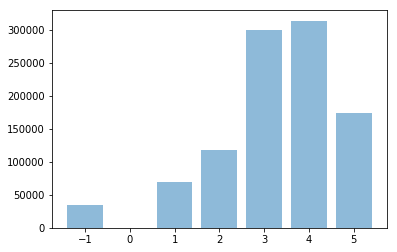

In [0]:
##data中各个ratings等级总数的图
pp=data.groupby(data.rating).count()
plt.bar(pp.index.values, pp.userId,align='center', alpha=0.5)

在评分数据集中-1到5，共7个等级，其中4分评价居首，3分其次，少有1和和-1的极端评价。可以发现用户总体态度较好，数据呈现轻微left skewed,不过考虑结合现实中评分的情况，本项目并没有对数据进行log transfer/standardize的处理。

下面来看看movies数据中豆瓣官方评分的情况：

In [0]:
print('用户最高评分为',max(movies.豆瓣评分))
print('用户最低评分为',min(movies.豆瓣评分))
print('用户平均评分为',np.mean(movies.豆瓣评分))

用户最高评分为 9.0
用户最低评分为 4.1
用户平均评分为 6.700602409638557


<BarContainer object of 166 artists>

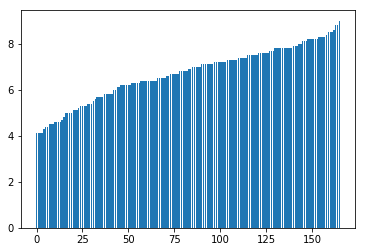

In [0]:
#####movies 数据中的评分bar图排列
oo=movies.sort_values(by=['豆瓣评分'])
plt.bar([i for i in range(len(oo))],oo.豆瓣评分, alpha=1)

In [0]:
####将movies数据按从小到大的顺序排列，并且选出分数大于7.5的数据

In [0]:
movies.sort_values(by=['豆瓣评分']).loc[oo['豆瓣评分'] > 8]

movieId  豆瓣评分                        title
35  10773239   8.1                          小男孩
11  25823132   8.1                           暗杀
64  26304167   8.1                          出租车
30  21937450   8.2                         国际市场
13  25766754   8.2                         年轻气盛
77  11520649   8.2                         麦克法兰
81   2973079   8.2                   霍比特人3：五军之战
10  25859495   8.2                           思悼
0   20645098   8.2                          小王子
24  25761178   8.3                         百元之恋
42  10741643   8.3                        我的个神啊
26  25855951   8.3                        贝利叶一家
1   26259677   8.3                         垫底辣妹
66  23761370   8.4                       速度与激情7
59  24405378   8.5                    王牌特工：特工学院
36  24397586   8.5                         小羊肖恩
60   3592854   8.5                 疯狂的麦克斯4：狂暴之路
16  25955491   8.6                         罪恶之家
12  10533913   8.8                        头脑特工队
14  26393561   8.8                     小萝莉的猴神大叔
91  19897541   9.0  机动战士高达 THE ORIGIN I 青瞳的卡斯巴尔

In [0]:
print('豆瓣评分中分数大于7.5的评分的电影总数为',len(movies.sort_values(by=['豆瓣评分']).loc[oo['豆瓣评分'] > 8]))

豆瓣评分中分数大于7.5的评分的电影总数为 21



我们可以看到在165部电影中分数大于7.5的评分的电影总数为21，仅占8分之1，我们当然可以向用户直接推荐这些官方评分分数较高的电影，特别是对于一些并没有过往评分记录的新用户（冷启动），这是确实是一个可行的办法。



另外，我们也可以参考data数据中已经存在的用户对于电影的评分，因为观众即大众的声音可能更具有代表性。下面我们用电影的用户平均评分来对电影进行名次排序：

由于raw data中movie id过于繁琐，我们先重新用从0开始的id对数据进行map id

In [0]:
########map处理
###map function
def mapping(col):
    mapp = {}
    i = 0
    for k in col.unique():
        mapp[k] = i
        i += 1
    return mapp
  
 #####map two variables
movieId_mapping =mapping(data["movieId"])
data["movieId"]=data["movieId"].map(movieId_mapping)

userId_mapping =mapping(data["userId"])
data["userId"]=data["userId"].map(userId_mapping)

userId_mapping =mapping(data["userId"])
data["userId"]=data["userId"].map(userId_mapping)

#####将movie数据的movieId也重新map 
movies["movieId"]=movies["movieId"].map(movieId_mapping)

######将data所有负1分都改成1分
data=data.replace(-1, 1)



In [0]:
######group by movieId并agg求出每部电影的mean评分
data_mean=data.groupby('movieId').agg(['mean'])
####将agg出来的结果命名
data_mean.columns = ['a', 'mean_ratings']
#####与带有电影名字的数据进行join，并按照平均分排序
data_mean.drop(columns=['a']).merge(movies, left_on='movieId', right_on='movieId').sort_values(by=['mean_ratings'],ascending=False).head(30)

movieId  mean_ratings  豆瓣评分                        title
90        90      4.346429   9.0  机动战士高达 THE ORIGIN I 青瞳的卡斯巴尔
11        11      4.338150   8.8                        头脑特工队
13        13      4.298995   8.8                     小萝莉的猴神大叔
58        58      4.225000   8.5                    王牌特工：特工学院
35        35      4.208012   8.5                         小羊肖恩
15        15      4.143590   8.6                         罪恶之家
25        25      4.100323   8.3                        贝利叶一家
59        59      4.071429   8.5                 疯狂的麦克斯4：狂暴之路
65        65      4.068965   8.4                       速度与激情7
23        23      4.068812   8.3                         百元之恋
41        41      4.068066   8.3                        我的个神啊
9          9      4.040000   8.2                           思悼
76        76      4.015068   8.2                         麦克法兰
29        29      3.980056   8.2                         国际市场
10        10      3.970544   8.1                           暗杀
34        34      3.962500   8.1                          小男孩
80        80      3.961967   8.2                   霍比特人3：五军之战
0          0      3.941917   8.2                          小王子
7          7      3.941343   8.0                         秘密特工
12        12      3.938525   8.2                         年轻气盛
17        17      3.916279   8.0                  我和厄尔以及将死的女孩
131      131      3.916000   7.9                         1944
63        63      3.888542   8.1                          出租车
56        56      3.845402   7.8                         可爱的你
79        79      3.843750   7.9                    花与爱丽丝杀人事件
24        24      3.843568   7.8                       福尔摩斯先生
19        19      3.824968   7.9                         烈日灼心
8          8      3.822515   7.8                           蚁人
46        46      3.816116   7.8                          愚人节
66        66      3.794122   7.8                    碟中谍5：神秘国度

从上面我们可以看出用户的心声其实大部分与豆瓣官方是相同的，只有小部分影片排行发生了些小规模的顺序变化，但这样的排行对于一个用户来说可能是更公正的，也是更有代表性的推荐方法。

上述两种方法虽然操作便捷简单，但推荐的局限较大，只适合最普遍基本的需求，这种泛化的推荐是远远不够的，下面然我们来构建模型，充分挖掘用户数据的信息，并构建更准确，更个性化的推荐。

## 4. 基于内容的协同推荐(item_based)


协同过滤的模型一般为m个物品，m个用户的数据，只有部分用户和部分数据之间是有评分数据的，其它部分评分是空白，我们需要使用已经有的数据建立一个系数矩阵并使用它来预测那些空白的物品和数据之间的评分关系，找到最高评分的物品推荐给用户。注意，这里我们的主要思想是：用户总会喜欢与自己喜欢的物品相近的物品。



在这里我们首先将data与movies数据集join到一起，便于推荐时也能看到电影的名字

In [0]:
merge_data=data.merge(movies, left_on='movieId', right_on='movieId')
merge_data.head()

userId  movieId  rating  豆瓣评分 title
0       0        0       4   8.2   小王子
1       1        0       3   8.2   小王子
2       2        0       2   8.2   小王子
3       3        0       3   8.2   小王子
4       4        0       4   8.2   小王子

下面来创造一个稀疏矩阵：matrix of users and movies

In [0]:
pivot=merge_data.pivot_table(index=['userId'],columns=['title'],values='rating')
pivot

title   1944  1980年代的爱情  一步之遥  万物生长  三城记  ...  魔镜   鸭王  麦克法兰  黑色弥撒  龙三和他的七人党
userId                                    ...                               
0        NaN        NaN   NaN   NaN  4.0  ... NaN  NaN   NaN   NaN       NaN
1        NaN        NaN   2.0   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
2        NaN        NaN   4.0   NaN  NaN  ... NaN  1.0   NaN   NaN       NaN
3        NaN        NaN   4.0   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
4        NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
5        NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
6        NaN        NaN   3.0   3.0  NaN  ... NaN  NaN   NaN   NaN       NaN
7        NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
8        NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
9        NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
10       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
11       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
12       NaN        4.0   4.0   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
13       NaN        NaN   5.0   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
14       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
15       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
16       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
17       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
18       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
19       NaN        NaN   NaN   3.0  NaN  ... NaN  NaN   NaN   NaN       NaN
20       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
21       NaN        NaN   NaN   NaN  NaN  ... NaN  2.0   NaN   NaN       NaN
22       NaN        NaN   4.0   3.0  NaN  ... NaN  NaN   NaN   NaN       NaN
23       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
24       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
25       NaN        NaN   NaN   1.0  NaN  ... NaN  NaN   NaN   NaN       NaN
26       NaN        NaN   2.0   3.0  NaN  ... NaN  NaN   NaN   NaN       NaN
27       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
28       NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
29       NaN        NaN   3.0   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
...      ...        ...   ...   ...  ...  ...  ..  ...   ...   ...       ...
223209   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223210   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223211   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223212   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223213   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223214   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223215   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223216   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223217   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223218   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223219   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223220   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223221   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223222   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223223   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223224   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223225   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223226   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       NaN
223227   NaN        NaN   NaN   NaN  NaN  ... NaN  NaN   NaN   NaN       

下面来算一个correlation matrix,为了排除那些评分的人数在100人以下的电影

这样我们通过找到物品间的[Pearson Correlation Coefficients](https://baike.baidu.com/item/Pearson%20Correlation%20Coefficients)来帮助我们找到了物品的corre_matrix.

In [0]:
####这样我们通过找到物品的pearson距离找到了物品corre_matrix

In [0]:
cor_matrix=pivot.corr(method='pearson',min_periods=100)
cor_matrix


title            1944  1980年代的爱情      一步之遥  ...      麦克法兰      黑色弥撒  龙三和他的七人党
title                                       ...                              
1944         1.000000        NaN  0.171209  ...       NaN       NaN       NaN
1980年代的爱情         NaN   1.000000  0.152066  ...       NaN       NaN       NaN
一步之遥         0.171209   0.152066  1.000000  ...  0.132699  0.104159  0.239550
万物生长              NaN   0.180998  0.211198  ...  0.242170  0.213599       NaN
三城记               NaN        NaN  0.239027  ...       NaN       NaN       NaN
二十                NaN        NaN  0.154560  ...  0.345105       NaN       NaN
代号47              NaN        NaN  0.153807  ...       NaN  0.370528       NaN
传奇                NaN        NaN       NaN  ...       NaN       NaN       NaN
侏罗纪世界             NaN        NaN  0.123337  ...  0.330762  0.233008  0.324137
侦探：为了原点           NaN        NaN       NaN  ...       NaN       NaN       NaN
假期历险记             NaN        NaN  0.048742  ...  0.289711  0.266389       NaN
像素大战              NaN        NaN  0.127793  ...  0.353467  0.262353  0.351716
内在美               NaN        NaN  0.118357  ...  0.478944  0.241438       NaN
军犬麦克斯             NaN        NaN  0.091573  ...       NaN       NaN       NaN
冲上云霄              NaN        NaN  0.120674  ...  0.284228       NaN       NaN
冲出康普顿             NaN        NaN  0.177789  ...       NaN       NaN       NaN
出租车               NaN        NaN  0.211761  ...       NaN       NaN       NaN
分歧者2：绝地反击         NaN        NaN  0.164773  ...  0.247672  0.257400       NaN
刺客聂隐娘             NaN        NaN       NaN  ...       NaN       NaN       NaN
匆匆那年              NaN   0.249592  0.091833  ...  0.125226  0.130905  0.234406
北京纽约              NaN        NaN  0.128131  ...       NaN       NaN       NaN
十万个冷笑话            NaN        NaN  0.153985  ...  0.285290  0.086550  0.286354
华丽上班族             NaN   0.238788  0.184953  ...  0.299853  0.106611  0.011960
博物馆奇妙夜3           NaN        NaN  0.156373  ...  0.337355  0.191516  0.205614
卫生间的圣母像           NaN        NaN  0.191848  ...       NaN       NaN       NaN
可爱的你              NaN        NaN  0.107946  ...  0.506739       NaN       NaN
命中注定              NaN   0.523171  0.165217  ...  0.184688  0.119023       NaN
咒怨：完结篇            NaN        NaN       NaN  ...       NaN       NaN       NaN
唇上之歌              NaN        NaN       NaN  ...       NaN       NaN       NaN
嘘！禁止想象！           NaN        NaN  0.131545  ...       NaN       NaN       NaN
...               ...        ...       ...  ...       ...       ...       ...
罪恶之家              NaN        NaN  0.130481  ...       NaN       NaN       NaN
美式极端              NaN        NaN  0.224246  ...       NaN  0.015251       NaN
老手                NaN        NaN  0.170924  ...  0.394511  0.278222  0.518088
致命礼物              NaN        NaN  0.138304  ...       NaN  0.301765       NaN
花与爱丽丝杀人事件         NaN        NaN  0.212833  ...  0.467925       NaN  0.382912
蚁人           0.296005   0.334142  0.103493  ...  0.408004  0.294425  0.287031
西部慢调              NaN        NaN  0.270249  ...  0.091313  0.143426       NaN
许三观               NaN        NaN  0.146337  ...  0.329550  0.242743  0.408814
贝利叶一家             NaN        NaN  0.139002  ...  0.394885  0.188254       NaN
贵族大盗              NaN        NaN  0.191622  ...  0.147561  0.305278       NaN
超能查派         0.067963   0.322211  0.117958  ...  0.381070  0.218206  0.391935
躲藏                NaN        NaN       NaN  ...       NaN       NaN       NaN
这时对那时错            NaN        NaN  0.116532  ...       NaN       NaN       NaN
这里的黎明静悄悄          NaN        NaN  0.048024  ...       NaN       NaN       NaN
进击的巨人真人版：前篇       NaN        NaN  0.048796  ...       NaN  0.404553  0.149110
远离尘嚣              NaN        NaN  0.182800  ...       NaN       NaN       NaN
速度与激情7       0.201029   0.303517  0.100373  ...  0.256589  0.201634  0.305508
道士下山        -0.054529   0.241199  0.217003  ...  0.278912  0.236886  0.268835
酷毙了               NaN 

下面我们利用这个矩阵试着做一些简单的推荐

对于用户id为666的用户：

In [0]:
####for 666
#####我们先在pivot表中找出666用户的所有评论记录，dropna
user_rating=pivot.loc[666].dropna()
user_rating

title
像素大战       2.0
博物馆奇妙夜3    4.0
头脑特工队      4.0
小王子        4.0
小羊肖恩       5.0
暗杀         4.0
机械姬        3.0
泰迪熊2       4.0
海绵宝宝       5.0
烈日灼心       4.0
超能查派       4.0
Name: 666, dtype: float64

我们可以发现这位观众倾向于奇幻动作型电影，下面我们来进行推荐：

这里我们的思路为使用correlation matrix找出每部电影与666号用户评价过的电影相似度乘以评价过的电影的评分作为相似该部电影的评分，并按评分从高到低对电影进行排序，并推荐前30.

In [0]:
recommend=pd.Series()
for i in range(len(user_rating)):
  similar_movies=cor_matrix[user_rating.index[i]].dropna().map(lambda x: x*user_rating[i])
  recommend=recommend.append(similar_movies)
###若此电影与多部电影有correlation，那么加上相应的评分求和
recommend=recommend.groupby(recommend.index).sum()
recommend.sort_values(inplace=True,ascending=False)
recommend.drop(labels=user_rating.index.values).head(20)

可爱的你         13.889584
愚人节          13.512790
假期历险记        13.341946
蚁人           13.327033
秘密特工         13.300515
疯狂外星人        13.276175
龙三和他的七人党     13.257176
内在美          13.242935
涉足荒野         12.936108
深夜食堂 电影版     12.838802
女间谍          12.482798
碟中谍5：神秘国度    12.463520
福尔摩斯先生       12.405485
爷们些          12.340394
麦克法兰         12.272007
海月姬          12.222569
铁拳           12.203311
贝利叶一家        12.053233
侏罗纪世界        12.015767
小萝莉的猴神大叔     11.986376
dtype: float64

在推荐出的电影中，我们可以看到有很多电影都是奇幻，情感悬疑和动作类型的电影，可见推荐的效果不错

In [0]:
####for 6666

In [0]:
user_rating=pivot.loc[6666].dropna()
user_rating

title
一步之遥          1.0
女间谍           1.0
奸臣            1.0
小王子           1.0
愚人节           1.0
捉妖记           1.0
海月姬           1.0
烈日灼心          1.0
百元之恋          1.0
秘密特工          1.0
花与爱丽丝杀人事件     1.0
蚁人            1.0
霍比特人3：五军之战    1.0
Name: 6666, dtype: float64

这里可以看到6666这位用户与666在观影选择上有相似之处，倾向于奇幻动作类，但少了些情感类的电影，并且这位用户很特别，评价过的电影全都是负分差评(为了模型的的准确和算法限制,我们将-1分换为了1分)，让我们来看看我们的模型会给出怎样的答案：

In [0]:
recommend=pd.Series()
for i in range(len(user_rating)):
  similar_movies=cor_matrix[user_rating.index[i]].dropna().map(lambda x: x*user_rating[i])
  recommend=recommend.append(similar_movies)
recommend=recommend.groupby(recommend.index).sum()
recommend.sort_values(inplace=True,ascending=False)
recommend.drop(labels=user_rating.index.values).head(20)

深夜食堂 电影版       4.218211
内在美            4.045367
暗杀             3.926936
福尔摩斯先生         3.924298
许三观            3.767648
老手             3.759447
我和厄尔以及将死的女孩    3.758439
贝利叶一家          3.755144
碟中谍5：神秘国度      3.704747
博物馆奇妙夜3        3.676991
寄生兽            3.610836
小男孩            3.598579
国际市场           3.548315
小黄人大眼萌         3.524848
杀破狼2           3.448743
爷们些            3.441079
小羊肖恩           3.430934
铁拳             3.421815
我的个神啊          3.412453
侏罗纪世界          3.411312
dtype: float64

这次推荐的结果同样可以接受，推荐出的电影大都是科幻，动作类的电影

但如果仔细观察出这个模型推荐出的结果，我们会发现一些问题：

1.推荐偏差：推荐结果中不乏像深夜食堂这样大众评分不高也不太符合用户喜好的电影。

2.误差无法量化：对于推荐出结果的准确性，我们只能通过感性的认知来衡量，只能是一个大概的判断，不能用一个具体的误差大小来量化错误率

为了解决这样的问题，我们引出下面的方法，即基于模型的协同过滤。

## 5. 基于模型的协同推荐



在这个板块中，我们首先将利用keras复现Koren在NetFlix大赛中的使用到的SVD算法以及其扩展出的RSVD，这两个模型也是推荐模型中现今使用比较广泛的两个模型。另外，我门将在RSVD的理论基础上作出修改和拓展，搭建出neural networks结构的推荐模型。我们也将展现出训练模型及predict和推荐的全过程



### 5. 1  SVD

SVD的主要思想是对于上述的用户与电影的评分稀疏矩阵$R_{U*I}$，我们总可以将其分解为两个矩阵的乘积，例如：

$$loss=\sum_{i,u}(r_{u,i}-\sum_{k=1}^KR_{U，I})^2$$

$$R_{U*I}=P_{U*K}\cdot Q_{K*I}$$


其中矩阵$P_{U*K}$表示用户的隐形特征矩阵，U表示用户数，I表示商品数，K则代表隐形特征的数量，$Q_{K*I}$则表示商品的隐形特征矩阵。这里的所谓隐形特征是指数据中没有列出的，但是隐性存在的影响用户对于电影评分的属性特征，例如影片的类型，导演，年代等等。我们使用keras 建立出这样的模型结构，并带入数据反复的学习，既可以找到每个隐形特征所对应的参数，即每位用户对于某种隐形特征的偏好，然后制定出个性化的推荐模型。

下面我们动手实现这个模型：

In [0]:
###取出原数据中"userId", "movieId", "rating" columns, 创建出data1
data1=data[["userId", "movieId", "rating"]]

In [0]:
#####将数据分为train 和test两部分
from sklearn.model_selection import train_test_split
train, test = train_test_split(data1, test_size=0.2, random_state=42)


搭建模型，定义为**model1_SVD**：（其中参数n_embedddings代表k,即隐形特征的数量）

In [0]:
def model1_SVD(n_embedddings):
    
    m_inputs = Input(shape=[1], dtype='int32')
    m = Embedding(len(movieId_mapping), n_embedddings, name="moiveId")(m_inputs)
    m=Flatten()(m)
    
    u_inputs = Input(shape=[1], dtype='int32')
    u =Embedding(len(userId_mapping),n_embedddings, name="user")(u_inputs)
    u=Flatten()(u)

    o=Dot(name="Dot_Product", axes=1)([m, u])
    
    model1 = Model(inputs=[m_inputs, u_inputs], outputs=o)
    model1.compile(loss='mse', optimizer='adam', metrics=["mae"])

    return model1

我们可以利用summary查看模型大致结构（先假设n_embedddings为5）

In [0]:
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
moiveId (Embedding)             (None, 1, 5)         825         input_21[0][0]                   
__________________________________________________________________________________________________
user (Embedding)                (None, 1, 5)         1116195     input_22[0][0]                   
__________________________________________________________________________________________________
flatten_20

我门可以看到即使当隐性特征的数据仅为5时，模型的参数量也非常的大，在训练时必定非常耗时。本项目是在google colab的环境下进行的，在训练中使用了TPU和大的mini_batch size 才加快了训练速度。

下面我们用cross_validation对模型进行调参：（在这里由于篇幅，省略掉了训练的过程output，完整版请参看github原文件）

In [0]:
###use cross vali to test best number of embedddings
n_embedddings=[5,10,15,20]

para=[]
vali_e=[]
for num in n_embedddings:
    model = model1_SVD(num)
    hist=model.fit([train.movieId, train.userId],train.rating, epochs=20,validation_split=0.2, verbose=1,batch_size=5000)
    vali_e.append(hist.history['val_mean_absolute_error'][-1])
    para.append(str(num))

In [0]:
para

['5', '10', '15', '20']

In [0]:
vali_e

[1.1367150037350673, 1.1255247895150093, 1.1319610909949889, 1.189047880629024]

下面用best parameter再对完整的training dataset进行训练：

In [0]:
model = model1_SVD(10)
hist=model.fit([train.movieId, train.userId],train.rating, epochs=50, verbose=0,batch_size=10000)

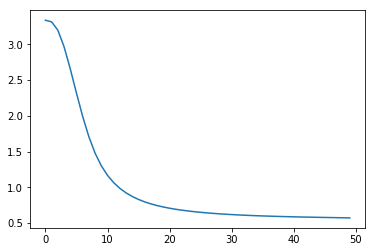

In [0]:
 plt.plot(hist.history['mean_absolute_error'])

我们将model放到test数据集上检测模型的质量：

In [0]:
model.evaluate([test.movieId, test.userId], test.rating)

201480/201480 [==============================] - 9s 44us/step


[2.204601116508914, 1.022160522888548]

可以发现这一种方法在train的数据集上表现的差强人意,mean_squared_error高达2.20，但绝对评分误差:为1.02,好像还可以接受，让我们来看看前十个prediction出的结果：

In [0]:
predictions = model.predict([test.movieId.head(10), test.userId.head(10)])
for i in range(10):
  print(predictions[i])
  print(test.rating.iloc[i])

[4.7828994]
4
[3.486517]
4
[4.1213994]
3
[1.9296036]
3
[-0.00330494]
3
[3.9816341]
4
[2.4274983]
5
[3.1382296]
3
[1.6597621]
1
[4.124352]
5


括号中的小数均是模型预测出的分数，可以发现效果还不错，但其中有几条数据偏差则较大，下面我们基于模型来搭建一个用户推荐程序：

In [0]:
def recomTop30_Vs_viewedTop30(id):
  #####创造出所有的电影id
  movie_data = np.array(list(set(data.movieId)))
######创造出相应人的list
  user=np.ones((len(movie_data)))*id
  ####perdict Recommend
  predictions = model.predict([movie_data, user])
  ####zip with users and sort by Recomm
  userRating_zip=np.hstack((movie_data.reshape(len(movie_data),1),predictions))
  userRating_zip=userRating_zip.tolist()
  userRating_zip.sort(key = lambda x: x[1],reverse=True) 
  ####get recommend top 30 id
  recomm_id=[]
  
  
  
  for i in range(30):
    recomm_id.append(int(userRating_zip[i][0]))
  print(recomm_id)
  
  ####filter viewed moive and select recommwnd  movie
  viewed_id=data.loc[data['userId']==id]['movieId'].values.tolist()
  notViewed_movies=movies[~movies['movieId'].isin(viewed_id)]####排除看过的电影
  recom_top30=notViewed_movies[notViewed_movies['movieId'].isin(recomm_id)]
  #####get top 30 in viewed movie
  viewed_high=data.loc[data['userId']==id].sort_values(by=['rating'], ascending=False).head(30)['movieId'].values.tolist()
  viewed_top30=movies[movies['movieId'].isin(viewed_high)]
  return recom_top30,viewed_top30
  
  

注意程序中返回的是model返还根据用户预测评分排序的前30，但若返回的30部电中存在有看过的电影，即从返回的列中删去此项，下面我们使用它来做出推荐：

In [0]:
#####对于用户666
recom_top30,viewed_top30=recomTop30_Vs_viewedTop30(666)

[11, 90, 13, 63, 35, 15, 25, 58, 23, 9, 59, 12, 76, 29, 65, 41, 37, 17, 7, 34, 131, 10, 33, 80, 79, 26, 24, 0, 31, 112]


In [0]:
##看过的电影
viewed_top30

movieId  豆瓣评分    title
0        0.0   8.2      小王子
2        1.0   7.2     海绵宝宝
11      10.0   8.1       暗杀
12      11.0   8.8    头脑特工队
20      19.0   7.9     烈日灼心
31      30.0   6.2     像素大战
36      35.0   8.5     小羊肖恩
71      70.0   7.5      机械姬
78      77.0   6.5     泰迪熊2
99      98.0   7.0  博物馆奇妙夜3
135    134.0   7.2     超能查派

In [0]:
##推荐的电影
recom_top30

movieId  豆瓣评分                        title
8        7.0   8.0                         秘密特工
10       9.0   8.2                           思悼
13      12.0   8.2                         年轻气盛
14      13.0   8.8                     小萝莉的猴神大叔
16      15.0   8.6                         罪恶之家
18      17.0   8.0                  我和厄尔以及将死的女孩
24      23.0   8.3                         百元之恋
25      24.0   7.8                       福尔摩斯先生
26      25.0   8.3                        贝利叶一家
27      26.0   7.7                         维多利亚
30      29.0   8.2                         国际市场
32      31.0   7.7                         旅程终点
34      33.0   7.8                         无境之兽
35      34.0   8.1                          小男孩
38      37.0   7.5                       这时对那时错
42      41.0   8.3                        我的个神啊
59      58.0   8.5                    王牌特工：特工学院
60      59.0   8.5                 疯狂的麦克斯4：狂暴之路
64      63.0   8.1                          出租车
66      65.0   8.4                       速度与激情7
77      76.0   8.2                         麦克法兰
80      79.0   7.9                    花与爱丽丝杀人事件
81      80.0   8.2                   霍比特人3：五军之战
91      90.0   9.0  机动战士高达 THE ORIGIN I 青瞳的卡斯巴尔
113    112.0   7.8                         金衣女人
132    131.0   7.9                         1944

In [0]:
######对于用户6666
recom_top30,viewed_top30=recomTop30_Vs_viewedTop30(6666)

[11, 63, 90, 35, 15, 13, 23, 58, 25, 12, 9, 59, 37, 76, 29, 65, 34, 41, 131, 7, 17, 10, 33, 80, 79, 31, 0, 161, 24, 26]


In [0]:
viewed_top30

movieId  豆瓣评分       title
0        0.0   8.2         小王子
8        7.0   8.0        秘密特工
9        8.0   7.8          蚁人
20      19.0   7.9        烈日灼心
24      23.0   8.3        百元之恋
40      39.0   6.4          奸臣
47      46.0   7.8         愚人节
50      49.0   7.6         女间谍
76      75.0   7.0         捉妖记
80      79.0   7.9   花与爱丽丝杀人事件
81      80.0   8.2  霍比特人3：五军之战
103    102.0   6.2        一步之遥
156    155.0   7.1         海月姬

In [0]:
recom_top30

movieId  豆瓣评分                        title
10       9.0   8.2                           思悼
11      10.0   8.1                           暗杀
12      11.0   8.8                        头脑特工队
13      12.0   8.2                         年轻气盛
14      13.0   8.8                     小萝莉的猴神大叔
16      15.0   8.6                         罪恶之家
18      17.0   8.0                  我和厄尔以及将死的女孩
25      24.0   7.8                       福尔摩斯先生
26      25.0   8.3                        贝利叶一家
27      26.0   7.7                         维多利亚
30      29.0   8.2                         国际市场
32      31.0   7.7                         旅程终点
34      33.0   7.8                         无境之兽
35      34.0   8.1                          小男孩
36      35.0   8.5                         小羊肖恩
38      37.0   7.5                       这时对那时错
42      41.0   8.3                        我的个神啊
59      58.0   8.5                    王牌特工：特工学院
60      59.0   8.5                 疯狂的麦克斯4：狂暴之路
64      63.0   8.1                          出租车
66      65.0   8.4                       速度与激情7
77      76.0   8.2                         麦克法兰
91      90.0   9.0  机动战士高达 THE ORIGIN I 青瞳的卡斯巴尔
132    131.0   7.9                         1944
162    161.0   7.8                         长寿商会

我们可以发现推荐的效果好像有了提升，推荐出的结果更加贴近用户的喜好，可以从豆瓣评分上看出推荐出的影片质量也有所提升。

与前面的基于物品的协同过滤推荐法我们可以发现对于用户666，推荐出的结果与前面用基于物品的协同推荐法的结果有些不同了，原本推荐中的一些评分较低的影片和与用户并不匹配的影片被另一些评分较高的影片所取代。对于用户6666，推荐出的影片则变化并不是很大，可能因为此用户对看过的电影评分一直较低，推荐系统也只能根据大众口味想起推荐平均评分较高的影片。

但对于这样的推荐方法有几个问题影响模型对用户个性化推荐的质量：

1：那就是模型中因为有受到总体影片评分的影响，例如类似豆瓣的媒体对影片的评分

2:个人的平均评分偏好也会影响模型质量，例如用户6666，在评分是全是1，但666平均评分会高出很高，这样3的分数可能对于6666是部上成的电影，但在666眼里却是部烂片

3:影片本身的性质，即电影的独有性质，类比于个人的评分偏好，可能某种类型的影片就不会有太高的评分等。

4.模型容易因为过拟合造成结果较差。



基于以上模型，我们有了下面SVD模型的变体RSVD。

### 5.2  RSVD

作为SVD的变体，RSVD的基本思想与SVD相同，主要结构也是两个隐性特征矩阵的成绩，但区别在于RSVD在模型中加入了用户和电影的独特变量，我们可以从loss function中来理解：

$$loss=\sum_{i,u}(r_{u,i}-\sum_{k=1}^KR_{U*I}-a)^2+\lambda_1\sum^UP_U^2+\lambda_2\sum^IQ_I^2+\lambda_3\sum^UB1_U^2+\lambda_4\sum^IB2_I^2$$
$$R_{U*I}=P_{U*K}\cdot Q_{K*I}+B1_u+B2_i$$

在上面的公式中，a代表总体影片评分的影响，B1代表个人的平均评分偏好的评分偏差，B1代表影片独有特质的带来的评分偏差。我们还可以发现在RSVdD的损失函数中我们加入了一系列的L2正则项，这样也避免了过拟合的风险，使得我们的模型变的更加泛化，能在推荐时推荐出更贴合用户偏好的个性化影片。

下面我们进行RSVD模型的定义和参数调整：

In [0]:
def model2_RSVD(n_embedddings,reg):
    # inputs
    val = np.random.random((1,1))
    var=K.variable(value=val)
    m_inputs = Input(shape=[1], dtype='int32')
    m = Embedding(len(movieId_mapping), n_embedddings, name="moive",embeddings_regularizer=regularizers.l2(reg))(m_inputs)
    m_bis = Embedding(len(movieId_mapping), 1, name="workbias",embeddings_regularizer=regularizers.l2(reg))(m_inputs)
    m=Flatten()(m)
    m_bis =Flatten()(m_bis)
    
    # context
    u_inputs = Input(shape=[1], dtype='int32')
    u = Embedding(len(userId_mapping),n_embedddings,name="user",embeddings_regularizer=regularizers.l2(reg))(u_inputs)
    u_bis = Embedding(len(userId_mapping), 1, name="userbias",embeddings_regularizer=regularizers.l2(reg))(u_inputs)
    u_bis=Flatten()(u_bis)
    u=Flatten()(u)

    o=Dot(name="Dot-Product", axes=1)([m, u])
    o=keras.layers.add([o,m_bis, u_bis])
    o=keras.layers.Lambda(lambda x: x +var)(o)
    
    rec_model = Model(inputs=[m_inputs, u_inputs], outputs=o)
    
    rec_model.compile(loss='mse', optimizer='adam', metrics=["mae"])

    return rec_model

我们同样先看看模型的结构（先假设n_embedddings=5,reg=0.1）

In [0]:
rec_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
moive (Embedding)               (None, 1, 5)         825         input_25[0][0]                   
__________________________________________________________________________________________________
user (Embedding)                (None, 1, 5)         1116195     input_26[0][0]                   
__________________________________________________________________________________________________
flatten_26

可以看到这里的模型比SVD有更多的参数，准确说多了22,000+个参数，这意味着训练的过程会更加繁琐漫长

In [0]:
###use cross vali to test best number of embedddings
#####因为参数较多，采用较大batch300来跑对比效果
n_embedddings=[5,10]
regular=[0.01,0.0000001]
para=[]
vali_e=[]
for num in n_embedddings:
  for reg in regular:
    model = model2_RSVD(num,reg)
    hist=model.fit([train.movieId, train.userId],train.rating, epochs=40,validation_split=0.2, verbose=2,batch_size=10000)
    vali_e.append(hist.history['val_mean_absolute_error'][-1])
    para.append(str(num)+'and'+str(reg))

同样这里省去了调参的结果，过程详见github原文件

In [0]:
#############
#####用best 参数和所有数据再跑一次model
model = model2_RSVD(5,0.0000001)
hist=model.fit([train.movieId, train.userId],train.rating, nb_epoch=45, verbose=1,batch_size=10000)

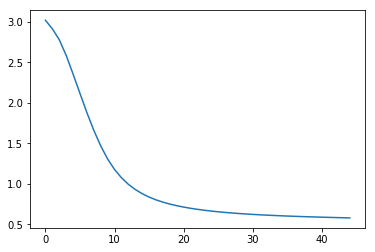

In [0]:
plt.plot(hist.history['mean_absolute_error'])

In [0]:
model.evaluate([test.movieId, test.userId], test.rating)

201480/201480 [==============================] - 18s 88us/step


[1.5534046969244304, 0.9079573710759481]

我们可以看到这个模型的效果又有了一步的提升，其mae甚至降低到了1以下，可谓是质的飞跃，可见在模型中加入用户偏见和电影是多么的重要。下面让我们看看实际推荐中的情况。

In [0]:

predictions = model.predict([test.movieId.head(10), test.userId.head(10)])
for i in range(10):
  print(predictions[i])
  print(test.rating.iloc[i])

[4.8685737]
4
[3.614464]
4
[4.1717863]
3
[1.9865336]
3
[0.95369154]
3
[3.9621341]
4
[2.4442012]
5
[3.1595368]
3
[1.7284298]
1
[4.1483006]
5


可以发现evaluate结果也明显好一些，但前十个评分缺不相上下来，看看对用户的推荐结果：

In [0]:
######for 666 again
recom_top30,viewed_top30=recomTop30_Vs_viewedTop30(666)

[11, 90, 13, 35, 63, 15, 25, 23, 9, 59, 12, 58, 76, 65, 41, 29, 34, 7, 17, 80, 10, 131, 37, 79, 0, 33, 24, 112, 46, 31]


In [0]:
viewed_top30

movieId  豆瓣评分    title
0        0.0   8.2      小王子
2        1.0   7.2     海绵宝宝
11      10.0   8.1       暗杀
12      11.0   8.8    头脑特工队
20      19.0   7.9     烈日灼心
31      30.0   6.2     像素大战
36      35.0   8.5     小羊肖恩
71      70.0   7.5      机械姬
78      77.0   6.5     泰迪熊2
99      98.0   7.0  博物馆奇妙夜3
135    134.0   7.2     超能查派

In [0]:
recom_top30

movieId  豆瓣评分                        title
8        7.0   8.0                         秘密特工
10       9.0   8.2                           思悼
13      12.0   8.2                         年轻气盛
14      13.0   8.8                     小萝莉的猴神大叔
16      15.0   8.6                         罪恶之家
18      17.0   8.0                  我和厄尔以及将死的女孩
24      23.0   8.3                         百元之恋
25      24.0   7.8                       福尔摩斯先生
26      25.0   8.3                        贝利叶一家
30      29.0   8.2                         国际市场
32      31.0   7.7                         旅程终点
34      33.0   7.8                         无境之兽
35      34.0   8.1                          小男孩
38      37.0   7.5                       这时对那时错
42      41.0   8.3                        我的个神啊
47      46.0   7.8                          愚人节
59      58.0   8.5                    王牌特工：特工学院
60      59.0   8.5                 疯狂的麦克斯4：狂暴之路
64      63.0   8.1                          出租车
66      65.0   8.4                       速度与激情7
77      76.0   8.2                         麦克法兰
80      79.0   7.9                    花与爱丽丝杀人事件
81      80.0   8.2                   霍比特人3：五军之战
91      90.0   9.0  机动战士高达 THE ORIGIN I 青瞳的卡斯巴尔
113    112.0   7.8                         金衣女人
132    131.0   7.9                         1944

In [0]:
#####for 6666 again 
recom_top30,viewed_top30=recomTop30_Vs_viewedTop30(6666)

[37, 58, 90, 131, 11, 108, 63, 9, 33, 36, 26, 161, 137, 25, 34, 31, 12, 35, 59, 76, 112, 15, 86, 13, 78, 156, 92, 23, 17, 7]


In [0]:
viewed_top30

movieId  豆瓣评分       title
0        0.0   8.2         小王子
8        7.0   8.0        秘密特工
9        8.0   7.8          蚁人
20      19.0   7.9        烈日灼心
24      23.0   8.3        百元之恋
40      39.0   6.4          奸臣
47      46.0   7.8         愚人节
50      49.0   7.6         女间谍
76      75.0   7.0         捉妖记
80      79.0   7.9   花与爱丽丝杀人事件
81      80.0   8.2  霍比特人3：五军之战
103    102.0   6.2        一步之遥
156    155.0   7.1         海月姬

In [0]:
recom_top30

movieId  豆瓣评分                        title
10       9.0   8.2                           思悼
12      11.0   8.8                        头脑特工队
13      12.0   8.2                         年轻气盛
14      13.0   8.8                     小萝莉的猴神大叔
16      15.0   8.6                         罪恶之家
18      17.0   8.0                  我和厄尔以及将死的女孩
26      25.0   8.3                        贝利叶一家
27      26.0   7.7                         维多利亚
32      31.0   7.7                         旅程终点
34      33.0   7.8                         无境之兽
35      34.0   8.1                          小男孩
36      35.0   8.5                         小羊肖恩
37      36.0   7.3                           橘色
38      37.0   7.5                       这时对那时错
59      58.0   8.5                    王牌特工：特工学院
60      59.0   8.5                 疯狂的麦克斯4：狂暴之路
64      63.0   8.1                          出租车
77      76.0   8.2                         麦克法兰
79      78.0   7.4                      卫生间的圣母像
87      86.0   7.6                     这里的黎明静悄悄
91      90.0   9.0  机动战士高达 THE ORIGIN I 青瞳的卡斯巴尔
93      92.0   7.6                         涉足荒野
109    108.0   7.5                         唇上之歌
113    112.0   7.8                         金衣女人
132    131.0   7.9                         1944
138    137.0   7.6                        冲出康普顿
157    156.0   7.4                         西部慢调
162    161.0   7.8                         长寿商会

可以发现这种方法推荐出的电影不仅质量上乘，并且推荐出的影片还非常有个人特色，可谓是真正的用户定制个性化推荐。即使面对喜好电影类型有重叠的两个人，其模型的推荐结果也能十分有针对性。但其缺点在训练时间较为冗长，效率稍微低了些。不过在GPU或是TPU的环境下，模型训练的效率还算可以接受。

### 5.3  Neural networks model

下面将介绍基于RSVD模型的基本原理设计的出的另一种推荐模型，这种模型中我们沿用了隐性特征的概念，同样保留了用户和电影的偏差项，但不同的是，并结合了少许deep learning的概念。在我们的模型中有一项与前面有所不同，我们并没有将两个隐性特征矩阵相乘作为最终rating的一部分，而是将两隐形特征矩阵与两个对应用户偏差和电影独特偏差的Embedding层相结合，并在将其flatten后进行线性组合，然后再经过一层activation为'Relu'方程的hidden layer后，进行线性组合为最后output，即评分项。

下面来定义模型结构：

In [0]:
def model3_NN(nodes_num,regular,n_embedddings):
    # inputs
    m_inputs = Input(shape=[1], dtype='int32')
    m = Embedding(len(movieId_mapping),n_embedddings, name="moive",embeddings_regularizer=regularizers.l2(regular))(m_inputs)
    m_bis = Embedding(len(movieId_mapping), 1, name="workbias",embeddings_regularizer=regularizers.l2(regular))(m_inputs)
    
    # context
    u_inputs = Input(shape=[1], dtype='int32')
    u = Embedding(len(userId_mapping),n_embedddings, name="user",embeddings_regularizer=regularizers.l2(regular))(u_inputs)
    u_bis = Embedding(len(userId_mapping), 1, name="userbias",embeddings_regularizer=regularizers.l2(regular))(u_inputs)

    o = concatenate([m,u,u_bis,m_bis])
    o = Flatten()(o)
    o = Dense(nodes_num, activation="relu")(o)
    o = Dense(1)(o)
 
    rec_model = Model(inputs=[m_inputs, u_inputs], outputs=o)
    rec_model.compile(loss='mse', optimizer='adam', metrics=["mae"])

    return rec_model

我们假设nodes_num=50,regular=0.1,n_embedddings=5，来看模型结构：

In [0]:
rec_model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
moive (Embedding)               (None, 1, 5)         825         input_30[0][0]                   
__________________________________________________________________________________________________
user (Embedding)                (None, 1, 5)         1116195     input_31[0][0]                   
__________________________________________________________________________________________________
userbias (

我们可以发现在hidden layer层node数量为50的情况下，参数的总数量还比上一种模型多出1000+个参数

下面进行调参：

In [0]:
###use cross vali to test best number of embedddings
#####因为参数较多，采用较大batch300来跑对比效果
regular=[0.1,0.01]
n_embedddings=[5]
nodes_num=[50,80,100]
para=[]
vali_e=[]
for nodes in nodes_num:
  for num in n_embedddings:
    for reg in regular:
      model = model3_NN(nodes,reg,num)
      hist=model.fit([train.movieId, train.userId],train.rating, epochs=40,validation_split=0.2, verbose=1,batch_size=10000)
      vali_e.append(hist.history['val_mean_absolute_error'][-1])
      para.append(str(num)+'and'+str(reg)+'and'+str(nodes))

In [0]:
para[vali_e.index(min(vali_e))]

'5and0.01and80'

In [0]:
#####用best 参数和所有数据再跑一次model
model = model3_NN(80,0.01,5)
hist=model.fit([train.movieId, train.userId],train.rating, epochs=45, verbose=2,batch_size=10000)

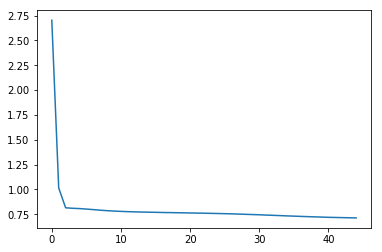

In [0]:
plt.plot(hist.history['mean_absolute_error'])

In [0]:
model.evaluate([test.movieId, test.userId], test.rating)

201480/201480 [==============================] - 17s 85us/step


[1.0898402347909284, 0.7662465228219342]

这里我们发现这个模型拟合的效果非常良好，不管是loss还是mae都有了大幅减少，推荐的精准度可谓剧增。那下面我们来看看这个模型世纪推荐的效果是怎样的：

In [0]:
predictions = model.predict([test.movieId.head(10), test.userId.head(10)])
for i in range(10):
  print(predictions[i])
  print(test.rating.iloc[i])

[4.095728]
4
[3.262094]
4
[3.6720762]
3
[1.9208113]
3
[2.7581372]
3
[4.0954447]
4
[2.592278]
5
[3.7741756]
3
[1.013023]
1
[4.1564755]
5


光看前十个推荐结果可发现确实分数准确度有增加

In [0]:
##for 666
recom_top30,viewed_top30=recomTop30_Vs_viewedTop30(666)

[11, 13, 90, 35, 9, 23, 15, 12, 59, 25, 63, 76, 41, 65, 29, 79, 58, 80, 7, 34, 0, 17, 112, 10, 56, 33, 62, 46, 26, 24]


In [0]:
viewed_top30

movieId  豆瓣评分    title
0        0.0   8.2      小王子
2        1.0   7.2     海绵宝宝
11      10.0   8.1       暗杀
12      11.0   8.8    头脑特工队
20      19.0   7.9     烈日灼心
31      30.0   6.2     像素大战
36      35.0   8.5     小羊肖恩
71      70.0   7.5      机械姬
78      77.0   6.5     泰迪熊2
99      98.0   7.0  博物馆奇妙夜3
135    134.0   7.2     超能查派

In [0]:
recom_top30

movieId  豆瓣评分                        title
8        7.0   8.0                         秘密特工
10       9.0   8.2                           思悼
13      12.0   8.2                         年轻气盛
14      13.0   8.8                     小萝莉的猴神大叔
16      15.0   8.6                         罪恶之家
18      17.0   8.0                  我和厄尔以及将死的女孩
24      23.0   8.3                         百元之恋
25      24.0   7.8                       福尔摩斯先生
26      25.0   8.3                        贝利叶一家
27      26.0   7.7                         维多利亚
30      29.0   8.2                         国际市场
34      33.0   7.8                         无境之兽
35      34.0   8.1                          小男孩
42      41.0   8.3                        我的个神啊
47      46.0   7.8                          愚人节
57      56.0   7.8                         可爱的你
59      58.0   8.5                    王牌特工：特工学院
60      59.0   8.5                 疯狂的麦克斯4：狂暴之路
63      62.0   7.6                          爷们些
64      63.0   8.1                          出租车
66      65.0   8.4                       速度与激情7
77      76.0   8.2                         麦克法兰
80      79.0   7.9                    花与爱丽丝杀人事件
81      80.0   8.2                   霍比特人3：五军之战
91      90.0   9.0  机动战士高达 THE ORIGIN I 青瞳的卡斯巴尔
113    112.0   7.8                         金衣女人

In [0]:
####6666

In [0]:
recom_top30,viewed_top30=recomTop30_Vs_viewedTop30(6666)

[11, 13, 90, 35, 9, 23, 15, 12, 59, 25, 63, 76, 41, 29, 58, 79, 65, 7, 17, 34, 112, 80, 10, 33, 62, 0, 56, 46, 24, 26]


In [0]:
viewed_top30

movieId  豆瓣评分       title
0        0.0   8.2         小王子
8        7.0   8.0        秘密特工
9        8.0   7.8          蚁人
20      19.0   7.9        烈日灼心
24      23.0   8.3        百元之恋
40      39.0   6.4          奸臣
47      46.0   7.8         愚人节
50      49.0   7.6         女间谍
76      75.0   7.0         捉妖记
80      79.0   7.9   花与爱丽丝杀人事件
81      80.0   8.2  霍比特人3：五军之战
103    102.0   6.2        一步之遥
156    155.0   7.1         海月姬

In [0]:
recom_top30

movieId  豆瓣评分                        title
10       9.0   8.2                           思悼
11      10.0   8.1                           暗杀
12      11.0   8.8                        头脑特工队
13      12.0   8.2                         年轻气盛
14      13.0   8.8                     小萝莉的猴神大叔
16      15.0   8.6                         罪恶之家
18      17.0   8.0                  我和厄尔以及将死的女孩
25      24.0   7.8                       福尔摩斯先生
26      25.0   8.3                        贝利叶一家
27      26.0   7.7                         维多利亚
30      29.0   8.2                         国际市场
34      33.0   7.8                         无境之兽
35      34.0   8.1                          小男孩
36      35.0   8.5                         小羊肖恩
42      41.0   8.3                        我的个神啊
57      56.0   7.8                         可爱的你
59      58.0   8.5                    王牌特工：特工学院
60      59.0   8.5                 疯狂的麦克斯4：狂暴之路
63      62.0   7.6                          爷们些
64      63.0   8.1                          出租车
66      65.0   8.4                       速度与激情7
77      76.0   8.2                         麦克法兰
91      90.0   9.0  机动战士高达 THE ORIGIN I 青瞳的卡斯巴尔
113    112.0   7.8                         金衣女人

从推荐的结果来看，推荐出的电影都是用户喜好电影所对应类型中的精品，对于两个用户，模型推荐出的电影相似度变高了，但细细看结果，发现即使的相同的电影，其推荐出的顺序确是有差别的，似乎这个模型对于用户对影片的评分敏感度更高。但同时也存在一定问题，那就是推荐出的电影泛化程度并没有RSVD的高，对于不同的用户，模型在训练时可能过于保守地追求更小的评分偏差，而放弃了向用户推荐那些可能评分不是那么高但会引起用户兴趣的影片。

从基于物品的协同推荐到三个基于模型的协同推荐，推荐模型的精确度和泛化性相较于基础模型都有所提升，其推荐的结果已经能较为代表性地体现出用户的偏好，并且推荐出的影片中也不乏同类型的高分好评影片。但在实际应用中，由于模型的结构造成了参数的数量过于庞大，不管是在调整参数还是预测上都会花不少的时间，从效率角度上讲便是一大弊端。

对于推荐系统这种大型的可并行运行进行训练的模型，分布式系统便是一个很好的解决方案。本文的下篇将运用spark中的ALS package，在分布式环境中训练推荐模型并作出预测及推荐。



